In [1]:
import pandas as pd

# Load the data
data = pd.read_csv('combined_data.csv')

# Display the first few rows of the data
data.head()


,ID,Timestamp,X,Y,Button,Duration
0,002-tf2-315,1.678903e+09,558,301,-1,-1.0
1,002-tf2-315,1.678903e+09,550,290,-1,-1.0
2,002-tf2-315,1.678903e+09,537,283,-1,-1.0
3,002-tf2-315,1.678903e+09,526,280,-1,-1.0
4,002-tf2-315,1.678903e+09,510,276,-1,-1.0


In [2]:
import numpy as np

def compute_additional_features(data):
    # Calculate differences for X and Y to compute velocity, acceleration, and angle
    data['Delta_X'] = data['X'].diff().fillna(0)
    data['Delta_Y'] = data['Y'].diff().fillna(0)
    
    # Compute Movement Distance (Euclidean distance)
    data['Movement_Distance'] = np.sqrt(data['Delta_X']**2 + data['Delta_Y']**2)
    
    # Compute Velocity (Distance / Time) - Assuming constant time intervals, the velocity is equivalent to movement distance
    data['Velocity'] = data['Movement_Distance']
    
    # Compute Acceleration (Change in Velocity / Time) - Using the same assumption as above
    data['Acceleration'] = data['Velocity'].diff().fillna(0)
    
    # Compute Angle of movement(angle of movement between consecutive data points using trigonometry.)
    data['Angle'] = np.arctan2(data['Delta_Y'], data['Delta_X']).fillna(0)
    
    # Calculate Jerk (rate of change of Acceleration)
    # The rate of change of acceleration. It can capture sudden movements.
    data['Jerk'] = data['Acceleration'].diff().fillna(0)
    
    # Calculate Curvature (change in angle over change in distance)
    # The degree to which a curve deviates from being flat or straight.
    data['Curvature'] = data['Angle'].diff().fillna(0) / (data['Movement_Distance'] + 1e-10)  # added a small value to prevent division by zero
    
    # Calculate Straightness (Euclidean distance between start and end over trajectory length)
    # Since we're working with individual points, we'll calculate this when creating sequences
    
    # Calculate Directional Changes (difference in angles between consecutive points)
    # Counting the number of times the movement changes direction can be indicative of certain behavioral patterns.
    data['Direction_Change'] = (data['Angle'].diff().fillna(0) != 0).astype(int)

    return data

# Apply the function to compute the additional features
data = compute_additional_features(data)

# Display the first few rows with the new features
data.head()


,ID,Timestamp,X,Y,Button,Duration,Delta_X,Delta_Y,Movement_Distance,Velocity,Acceleration,Angle,Jerk,Curvature,Direction_Change
0,002-tf2-315,1.678903e+09,558,301,-1,-1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,002-tf2-315,1.678903e+09,550,290,-1,-1.0,-8.0,-11.0,13.601471,13.601471,13.601471,-2.199593,13.601471,-0.161717,1
2,002-tf2-315,1.678903e+09,537,283,-1,-1.0,-13.0,-7.0,14.764823,14.764823,1.163353,-2.647651,-12.438118,-0.030346,1
3,002-tf2-315,1.678903e+09,526,280,-1,-1.0,-11.0,-3.0,11.401754,11.401754,-3.363069,-2.875341,-4.526421,-0.019970,1
4,002-tf2-315,1.678903e+09,510,276,-1,-1.0,-16.0,-4.0,16.492423,16.492423,5.090668,-2.896614,8.453737,-0.001290,1


In [4]:
# adding stop duration

def compute_stop_duration(data, threshold=0.001):
    """
    Compute the stop duration based on movement distance.
    """
    # Identify stops (when movement distance is below threshold)
    data['Is_Stop'] = (data['Movement_Distance'] < threshold).astype(int)
    
    # Calculate stop duration
    data['Stop_Duration'] = data['Is_Stop'] * data['Duration']

    return data

# Apply the function to compute the stop duration
data = compute_stop_duration(data)

# Display the first few rows with the new feature
data.head()


,ID,Timestamp,X,Y,Button,Duration,Delta_X,Delta_Y,Movement_Distance,Velocity,Acceleration,Angle,Jerk,Curvature,Direction_Change,Is_Stop,Stop_Duration
0,002-tf2-315,1.678903e+09,558,301,-1,-1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,-1.0
1,002-tf2-315,1.678903e+09,550,290,-1,-1.0,-8.0,-11.0,13.601471,13.601471,13.601471,-2.199593,13.601471,-0.161717,1,0,-0.0
2,002-tf2-315,1.678903e+09,537,283,-1,-1.0,-13.0,-7.0,14.764823,14.764823,1.163353,-2.647651,-12.438118,-0.030346,1,0,-0.0
3,002-tf2-315,1.678903e+09,526,280,-1,-1.0,-11.0,-3.0,11.401754,11.401754,-3.363069,-2.875341,-4.526421,-0.019970,1,0,-0.0
4,002-tf2-315,1.678903e+09,510,276,-1,-1.0,-16.0,-4.0,16.492423,16.492423,5.090668,-2.896614,8.453737,-0.001290,1,0,-0.0


In [5]:
# List of columns to select
selected_columns = ['Y', 'Stop_Duration', 'X', 'Jerk', 'Direction_Change', 'Movement_Distance', 'Acceleration', 'Button', 'Angle', 'ID']

# Select the desired columns
df_selected = data[selected_columns]
df_selected.head()

,Y,Stop_Duration,X,Jerk,Direction_Change,Movement_Distance,Acceleration,Button,Angle,ID
0,301,-1.0,558,0.000000,0,0.000000,0.000000,-1,0.000000,002-tf2-315
1,290,-0.0,550,13.601471,1,13.601471,13.601471,-1,-2.199593,002-tf2-315
2,283,-0.0,537,-12.438118,1,14.764823,1.163353,-1,-2.647651,002-tf2-315
3,280,-0.0,526,-4.526421,1,11.401754,-3.363069,-1,-2.875341,002-tf2-315
4,276,-0.0,510,8.453737,1,16.492423,5.090668,-1,-2.896614,002-tf2-315


C:\Users\drago\AppData\Local\Temp\ipykernel_8260\1618561295.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_selected.corr()


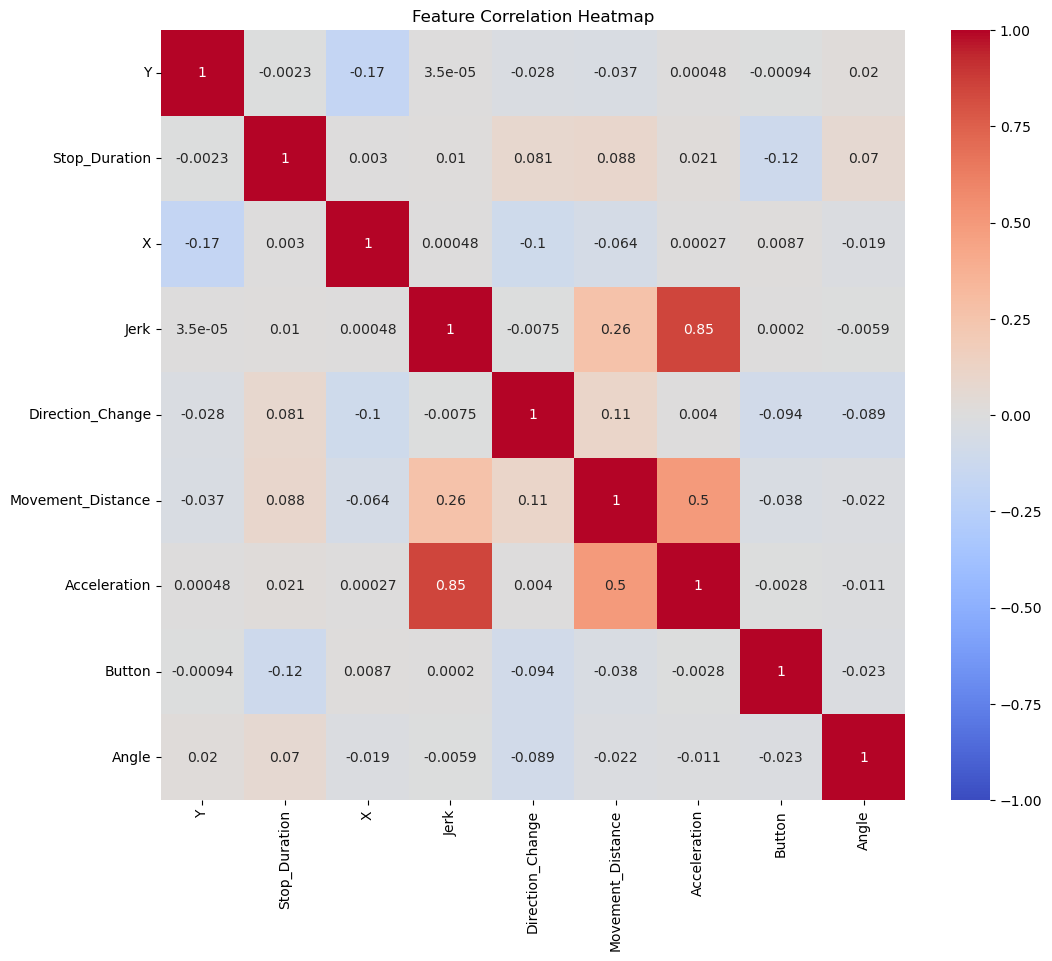

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_selected.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()


In [7]:
# Drop first row all ID

# Define a function to drop the first row for each group (User_ID)
def drop_first_row(group):
    return group.iloc[1:]

# Apply the function to each group defined by 'User_ID' and concatenate the results
df_selected = df_selected.groupby('ID').apply(drop_first_row).reset_index(drop=True)


In [8]:
df_selected

,Y,Stop_Duration,X,Jerk,Direction_Change,Movement_Distance,Acceleration,Button,Angle,ID
0,500,-0.0,579,-319.936258,1,2.236068,-164.440265,-1,-0.463648,001-tf2-315
1,499,-0.0,580,163.618411,1,1.414214,-0.821854,-1,-0.785398,001-tf2-315
2,499,-0.0,581,0.407641,1,1.000000,-0.414214,-1,0.000000,001-tf2-315
3,499,-0.0,583,1.414214,0,2.000000,1.000000,-1,0.000000,001-tf2-315
4,499,-0.0,584,-2.000000,0,1.000000,-1.000000,-1,0.000000,001-tf2-315
...,...,...,...,...,...,...,...,...,...,...
1202664,539,-0.0,961,0.000000,1,1.414214,0.000000,-1,-0.785398,021-tf2-403
1202665,539,-0.0,960,-0.414214,1,1.000000,-0.414214,-1,3.141593,021-tf2-403
1202666,540,-0.0,961,0.828427,1,1.414214,0.414214,-1,0.785398,021-tf2-403
1202667,540,-1.0,961,-1.828427,1,0.000000,-1.414214,-1,0.000000,021-tf2-403


In [10]:
df_selected['user_id'] = df_selected['ID'].str.extract(r'^0*(\d+)-').astype(int)
df_selected

,Y,Stop_Duration,X,Jerk,Direction_Change,Movement_Distance,Acceleration,Button,Angle,ID,user_id
0,500,-0.0,579,-319.936258,1,2.236068,-164.440265,-1,-0.463648,001-tf2-315,1
1,499,-0.0,580,163.618411,1,1.414214,-0.821854,-1,-0.785398,001-tf2-315,1
2,499,-0.0,581,0.407641,1,1.000000,-0.414214,-1,0.000000,001-tf2-315,1
3,499,-0.0,583,1.414214,0,2.000000,1.000000,-1,0.000000,001-tf2-315,1
4,499,-0.0,584,-2.000000,0,1.000000,-1.000000,-1,0.000000,001-tf2-315,1
...,...,...,...,...,...,...,...,...,...,...,...
1202664,539,-0.0,961,0.000000,1,1.414214,0.000000,-1,-0.785398,021-tf2-403,21
1202665,539,-0.0,960,-0.414214,1,1.000000,-0.414214,-1,3.141593,021-tf2-403,21
1202666,540,-0.0,961,0.828427,1,1.414214,0.414214,-1,0.785398,021-tf2-403,21
1202667,540,-1.0,961,-1.828427,1,0.000000,-1.414214,-1,0.000000,021-tf2-403,21


In [12]:
df_selected['ID'].unique()

array(['001-tf2-315', '002-tf2-315', '004-poly-315', '004-tf2-315',
       '005-poly-315', '007-poly-317', '007-tf2-317', '008-poly-317',
       '008-tf2-317', '009-poly-320', '009-tf2-320', '010-poly-317',
       '010-tf2-320', '011-poly-326', '012-poly-326', '013-poly-326',
       '013-tf2-326', '014-poly-328', '014-tf2-328', '015-poly-328',
       '015-tf2-328', '016-tf2-328', '017-tf2-328', '018-poly-330',
       '018-tf2-330', '019-poly-403', '019-tf2-403', '020-poly-403',
       '020-tf2-403', '021-tf2-403'], dtype=object)

In [21]:
desired_ids = [4, 7, 8, 9, 10, 14, 13, 15, 18, 20]
filtered_df = df_selected[df_selected['user_id'].isin(desired_ids)]


In [22]:
filtered_df['user_id'].unique()

array([ 4,  7,  8,  9, 10, 13, 14, 15, 18, 20])

In [23]:
filtered_df

,Y,Stop_Duration,X,Jerk,Direction_Change,Movement_Distance,Acceleration,Button,Angle,ID,user_id
68693,646,-0.0,1488,-1928.597197,1,26.400758,-951.598220,-1,-2.490516,004-poly-315,4
68694,630,-0.0,1466,952.400403,1,27.202941,0.802183,-1,-2.512796,004-poly-315,4
68695,612,-0.0,1438,5.281509,1,33.286634,6.083693,-1,-2.570255,004-poly-315,4
68696,590,-0.0,1408,-2.168176,1,37.202150,3.915517,-1,-2.508844,004-poly-315,4
68697,559,-0.0,1367,10.282722,1,51.400389,14.198239,-1,-2.494201,004-poly-315,4
...,...,...,...,...,...,...,...,...,...,...,...
1160733,541,-0.0,960,1.000000,1,1.000000,1.000000,-1,1.570796,020-tf2-403,20
1160734,541,-1.0,960,-2.000000,1,0.000000,-1.000000,-1,0.000000,020-tf2-403,20
1160735,542,-0.0,960,2.000000,1,1.000000,1.000000,-1,1.570796,020-tf2-403,20
1160736,540,-0.0,960,0.000000,1,2.000000,1.000000,-1,-1.570796,020-tf2-403,20


In [24]:
filtered_df.to_csv('Both_play.csv')